# Homework6: Flow matching models

## Task 1: Theory (5pt)

### Problem 1: KFP theorem (1pt)

We have faced with 2 different formulations of Kolmogorov-Fokker-Planck theorem.

1) continuity equation in continuous-in-time NF:
$$
\frac{d \log p(\mathbf{x}(t), t)}{d t} = - \text{tr} \left( \frac{\partial f(\mathbf{x}, t)}{\partial \mathbf{x}} \right);
$$

2) the general form of the KFP equation in SDEs:
$$
\frac{\partial p(\mathbf{x}, t)}{\partial t} = - \text{div}\left(\mathbf{f}(\mathbf{x}, t) p(\mathbf{x}, t)\right) + \frac{1}{2} g^2(t) \Delta p(\mathbf{x}, t).
$$

In this task your goal is to prove that the first formulation is a special case of the more general second formulation.

**Note:** The derivation in the first formulation is total derivative (not partial).

```
your solution
```

### Problem 2: DDPM as SDE discretization (2pt)

We have proved that DDPM is a discretization of the SDE
$$
	d \mathbf{x} = - \frac{1}{2} \beta(t) \mathbf{x}(t) dt + \sqrt{\beta(t)} \cdot d \mathbf{w}.
$$
Here $\mathbf{f}(\mathbf{x}, t) = - \frac{1}{2} \beta(t) \mathbf{x}(t)$, $g(t) = \sqrt{\beta(t)}$.

Recall reverse SDE
$$
    d\mathbf{x} = \left(\mathbf{f}(\mathbf{x}, t) - g^2(t) \frac{\partial \log p_t(\mathbf{x})}{\partial \mathbf{x}}\right) dt + g(t) d \mathbf{w}.
$$

The reverse SDE of the DDPM model will be
$$
    d\mathbf{x}(t) = -\beta(t)\left[\frac{x(t)}{2} + \nabla_{\mathbf{x}}\log p_t(\mathbf{x}(t))\right]dt + \sqrt{\beta(t)}d\mathbf{w}.
$$

The DDPM uses the following form of ancestral sampling
$$
\mathbf{x}_{t-1} = \frac{1}{\sqrt{1 - \beta_t}} \cdot \mathbf{x}_t + \frac{\beta_t}{\sqrt{1 - \beta_t}} \cdot \nabla_{\mathbf{x}_t} \log p(\mathbf{x}_t | \boldsymbol{\theta}) +  \sqrt{\beta_t} \cdot \boldsymbol{\epsilon}.
$$
(Here we assumed that $p(\mathbf{x}_{t - 1} | \mathbf{x}_t, \boldsymbol{\theta}) = \mathcal{N} \left(\boldsymbol{\mu}_{\boldsymbol{\theta}, t}(\mathbf{x}_t), \beta_t \cdot \mathbf{I}\right)$).

Here is your task to validate that DDPM iterative update scheme is actually discretization of SDE by letting $t \in \{0,\ldots,\frac{N-1}{N}\}$, $\Delta t = 1/N$, $\mathbf{x}(t-\Delta t) = \mathbf{x}_{s-s}$, $\mathbf{x}(t) = \mathbf{x}_s$, and $\beta(t)\Delta t = \beta_s$, s.e.:

In this task your goal is to show that the ancestral sampling is a discretization of the DDPM reverse SDE.

**Hints**:
1. use $dt < 0$;
2. $\beta_t = - \beta(t) dt$;
3. $d\mathbf{w} = \boldsymbol{\epsilon} \cdot \sqrt{-dt}$;
4. drop the terms with the order of $o(dt)$.

```
your solution
```

### Problem 3: Covariance of the Forward SDE (2pt)

From [Lecture 11](https://github.com/r-isachenko/2025-DGM-MIPT-YSDA-course/blob/main/lectures/lecture11/Lecture11.pdf) we know that the forward SDE

$$
d\mathbf{x}= \mathbf{f}(\mathbf{x},t)\,dt + g(t)\,d\mathbf{w}
$$

has conditional moments

$$
\frac{d}{dt}\mu\bigl(\mathbf{x}(t),\mathbf{x}(0)\bigr)
 = \mathbb{E}\bigl[\mathbf{f}\bigl(\mathbf{x}(t),t\bigr)\mid\mathbf{x}(0)\bigr],
$$

$$
\frac{d}{dt}\Sigma\bigl(\mathbf{x}(t),\mathbf{x}(0)\bigr)
 = \mathbb{E}\bigl[\mathbf{f}\,(\mathbf{x}(t)-\mu)^{\top}+(\mathbf{x}(t)-\mu)\mathbf{f}^{\top}\mid\mathbf{x}(0)\bigr] + g^{2}(t)\mathbf{I}.
$$

Your goal is to prove the covariance identity shown above.


```
your solution
```

In [ ]:
COMMIT_HASH = "79dfd7865ba692235f0a4d5aed20ee2820a19007"
!if [ -d dgm_utils ]; then rm -Rf dgm_utils; fi
!git clone https://github.com/r-isachenko/dgm_utils.git
%cd dgm_utils
!git checkout {COMMIT_HASH}
!pip install ./
%cd ./..
!rm -Rf dgm_utils

In [ ]:
from dgm_utils import load_dataset, BaseModel, train_model
from dgm_utils import visualize_images, show_samples, LabeledDataset

In [ ]:
from typing import Dict, List, Optional, Tuple
from tqdm.auto import tqdm

import numpy as np
import ot as pot

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data

from torchdiffeq import odeint

if torch.cuda.is_available():
    DEVICE = "cuda"
    print('GPU found :)') 
else: 
    DEVICE = "cpu"
    print('GPU not found :(')

## Task 2: Flow matching on MNIST (4 pt) 

In this task, you will train **Flow matching** model, focusing on its sampling capabilities. See the [Lecture 11](https://github.com/r-isachenko/2025-DGM-MIPT-YSDA-course/blob/main/lectures/lecture11/Lecture11.pdf), [Lecture 12](https://github.com/r-isachenko/2025-DGM-MIPT-YSDA-course/blob/main/lectures/lecture12/Lecture12.pdf) and [paper](https://arxiv.org/abs/2210.02747) for details.

In [ ]:
train_data, test_data = load_dataset("mnist", flatten=False, binarize=False)
visualize_images(train_data, "MNIST samples")

As in the previous assignments, we will use a U-Net architecture. This time, however, we will change it with continuous time embedding layer. Previously, our models operated with discrete timesteps, but now we need an embedding that can handle any time $t \in [0,1]$.

In [ ]:
class TimeEmbedding(nn.Module):
    def __init__(
        self, 
        dim_in: int, 
        dim_out: int, 
    ):
        super().__init__()
        assert dim_in % 2 == 0
        # ====
        # your code
        # create random frequencies for sinusoidal embeddings

        # ====

        # register as buffer to move to device with model
        self.register_buffer("freqs", freqs)

        # ====
        # your code
        # create MLP to process sinusoidal embeddings

        # ====

    def forward(self, t: torch.Tensor) -> torch.Tensor:
        t = t.float()
        if t.dim() == 1:
            t = t.unsqueeze(-1)

        # ====
        # your code
        # compute sinusoidal embeddings for t using self.freqs
        # and pass them through MLP (self.net)

        # ====
        return emb

def test_time_embedding():
    dim_in, dim_out = 4, 4
    embedding = TimeEmbedding(dim_in=dim_in, dim_out=dim_out)
    assert embedding.freqs.shape == (dim_in // 2,), \
        f"Wrong freqs shape: got {embedding.freqs.shape}, expected {(dim_in // 2,)}"

    embedding.net = nn.Identity()
    with torch.no_grad():
        embedding.freqs.copy_(torch.tensor([0.7, 1.3], dtype=torch.float32))
    t = torch.tensor([0.0, 0.25, 0.7, 1.0])
    freqs = embedding(t)
    expected = torch.tensor([
        [0.0000, 0.0000, 1.0000, 1.0000],
        [0.1741, 0.3193, 0.9847, 0.9477],
        [0.4706, 0.7895, 0.8823, 0.6137],
        [0.6442, 0.9636, 0.7648, 0.2675]
    ], dtype=freqs.dtype)

    assert freqs.shape == expected.shape, f"Wrong shape: got {freqs.shape}, expected {expected.shape}"
    assert torch.allclose(freqs, expected, atol=1e-4), f"Wrong values!\nGot:\n{freqs}\nExpected:\n{expected}"


test_time_embedding()

The `ResBlock`, `DownsampleBlock` and `UpsampleBlock` would be the same as in previous homework.

In [ ]:
class AdaGN(nn.GroupNorm):
    def __init__(
        self, 
        num_groups: int, 
        num_channels: int, 
        cond_dim: int, 
    ):
        # GroupNorm without affine, since scale and shift come from cond
        super().__init__(num_groups=num_groups, num_channels=num_channels, affine=False)
        hidden_dim = 2 * cond_dim

        # ====
        # your code
        # simple MLP with two heads for scale and shift

        # ====

    def forward(self, x, cond):
        # ====
        # your code
        # 1) apply GroupNorm via super()
        # 2) compute scale and shift using implemented networks
        # 3) extend scale and shift to match x and apply affine transformation

        # ====

        return out

In [ ]:
class AttnBlock(nn.Module):
    def __init__(self, in_dim: int):
        super().__init__()
        self.group_norm = nn.GroupNorm(32, in_dim)
        self.proj_q = nn.Conv2d(in_dim, in_dim, kernel_size=1, stride=1, padding=0)
        self.proj_k = nn.Conv2d(in_dim, in_dim, kernel_size=1, stride=1, padding=0)
        self.proj_v = nn.Conv2d(in_dim, in_dim, kernel_size=1, stride=1, padding=0)
        self.proj = nn.Conv2d(in_dim, in_dim, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        B, C, H, W = x.shape
        h = self.group_norm(x)
        q = self.proj_q(h)
        k = self.proj_k(h)
        v = self.proj_v(h)
        
        q = q.permute(0, 2, 3, 1).view(B, H * W, C) 
        k = k.view(B, C, H * W)
        w = torch.bmm(q, k) * (int(C) ** (-0.5))
        assert list(w.shape) == [B, H * W, H * W]
        w = F.softmax(w, dim=-1)
        
        v = v.permute(0, 2, 3, 1).view(B, H * W, C) 
        h = torch.bmm(w, v)
        assert list(h.shape) == [B, H * W, C]
        h = h.view(B, H, W, C).permute(0, 3, 1, 2)
        h = self.proj(h)
        
        return x + h
    

class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, cond_dim, dropout, attn=False):
        super().__init__()
        
        self.temb_proj = nn.Sequential(nn.SiLU(), nn.Linear(cond_dim, out_channels))

        # ====
        # your code
        # create two convolutional blocks and two AdaGN
        # it is preferable to start blocks from nn.SiLU and nn.Dropout

        # ====

        self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else nn.Identity()
        self.attn = AttnBlock(out_channels) if attn else nn.Identity()

    
    def forward(self, x, temb):
        # ====
        # your code
        # 1) compute embeddings
        # 2) pass x through the first block with embeddings
        # 3) pass the result through the second block with embeddings
        # 4) add the shortcut
        # 5) pass the result through the attention block

        # ====
        return h

In [ ]:
class DownsampleBlock(nn.Module):
    def __init__(self, channels: int):
        super().__init__()
        # ====
        # your code 
        # define convolutional layer that:
        # 1) does not change the number of channels
        # 2) reduces the size of the image twice

        # ====

    def forward(self, input_tensor: torch.Tensor, *args) -> torch.Tensor:
        # ====
        # your code

        # ====
        return x

class UpsampleBlock(nn.Module):
    def __init__(self, channels: int):
        super().__init__()
        # ====
        # your code 
        # define convolutional layer that:
        # 1) does not change the number of channels
        # 2) does not reduce the size of the image

        # ====

    def forward(self, input_tensor: torch.Tensor, *args) -> torch.Tensor:
        # ====
        # your code
        # 1) upsample the input tensor using bilinear interpolation
        # 2) pass the result through the convolutional layer

        # ====
        return x

Finally, we define the complete `UNet` - the neural network backbone of our diffusion model that handles both encoding and decoding with skip connections. Look at the code carefully.

In [14]:
class UNet(nn.Module):
    def __init__(
        self, 
        hidden_channels: int, 
        channel_multipliers: List[int], 
        num_blocks: int = 1,
        dropout: float = 0.1
    ):
        super().__init__()
        
        temb_dim = hidden_channels * 4
        self.time_embedding = TimeEmbedding(hidden_channels, temb_dim)
        self.head = nn.Conv2d(1, hidden_channels, kernel_size=3, stride=1, padding=1)
        channel_list, curr_channels = [hidden_channels], hidden_channels

        # initialization of downsample blocks
        self.downsample_blocks = nn.ModuleList()
        for idx, scale in enumerate(channel_multipliers):
            out_channels = hidden_channels * scale
            is_last = (idx == len(channel_multipliers) - 1)

            # make multiple ResBlocks at each scale
            for _ in range(num_blocks):
                # at each channel_multipliers scale we add ResBlock
                # last block has attention
                self.downsample_blocks.append(
                    ResBlock(curr_channels, out_channels, temb_dim, dropout, attn=True)
                )
                curr_channels = out_channels
                channel_list.append(curr_channels)

            # add downsample block if not last block
            if not is_last:
                self.downsample_blocks.append(DownsampleBlock(curr_channels))
                channel_list.append(curr_channels)
        
        # initialization of bottleneck block
        self.bottleneck = nn.ModuleList([
            ResBlock(curr_channels, curr_channels, temb_dim, dropout, attn=True),
            ResBlock(curr_channels, curr_channels, temb_dim, dropout, attn=False)
        ])
        
        # initialization of upsample blocks
        self.upsample_blocks = nn.ModuleList()
        for idx, scale in reversed(list(enumerate(channel_multipliers))):
            out_channels = hidden_channels * scale
            is_first, is_last = (idx == 0), (idx == len(channel_multipliers) - 1)

            # make multiple ResBlocks at each scale
            for _ in range(num_blocks + 1):
                # at each reverse channel_multipliers scale we add ResBlock
                # first block has attention
                self.upsample_blocks.append(
                    ResBlock(channel_list.pop() + curr_channels, out_channels, temb_dim, dropout, attn=False)
                )
            
                curr_channels = out_channels
            
            # add upsample block if not last block
            if not is_first:
                self.upsample_blocks.append(UpsampleBlock(curr_channels))
                
        self.tail = nn.Sequential(
            nn.GroupNorm(32, curr_channels),
            nn.SiLU(),
            nn.Conv2d(curr_channels, 1, kernel_size=3, stride=1, padding=1)
        )

    def forward(self, x, t, y=None):
        temb = self.time_embedding(t)

        h = self.head(x)
        skip_connections = [h] # save intermediate results for skip connections

        # downsample
        for layer in self.downsample_blocks:
            h = layer(h, temb)
            skip_connections.append(h) # save intermediate results for skip connections

        # bottleneck
        for layer in self.bottleneck:
            h = layer(h, temb)
        
        # upsample
        for layer in self.upsample_blocks:
            if isinstance(layer, ResBlock): # apply skip connection
                skip_connection = skip_connections.pop()
                h = torch.cat([h, skip_connection], dim=1)
            h = layer(h, temb)

        h = self.tail(h)
        return h

def test_unet():
    model = UNet(
        hidden_channels=128, 
        channel_multipliers=[1, 2, 4], 
    )
    x = torch.rand((2, 1, 32, 32))
    y = torch.zeros(size=(2,), dtype=torch.long)
    t = torch.zeros(size=(2,), dtype=torch.long)
    out1 = model(x, t, y)
    t = torch.ones(size=(2,), dtype=torch.long)
    out2 = model(x, t, y)
    assert not np.allclose(out1.detach().numpy(), out2.detach().numpy())


test_unet()

In conditional flow matching, our objective is to learn a vector field $ f_\theta(\mathbf{x}; t) $, parameterized by a neural network, that aligns with a known target vector field $f(\mathbf{x}; \mathbf{x}_1, t)$ at each point along a path connecting the data distribution and a base distribution. So, the training objective is defined as:

$$
\min_\theta\, \mathbb{E}_{t \sim U[0, 1]}\, \mathbb{E}_{\mathbf{x}_1 \sim p(\mathbf{x}_1)} \mathbb{E}_{\mathbf{x} \sim p_t(\mathbf{x} | \mathbf{x}_1)} \left[ \left\| f(\mathbf{x}; \mathbf{x}_1, t) - f_\theta(\mathbf{x}; t) \right\|^2 \right],
$$

In this task, we consider the **optimal transport conditional vector field**, defined by:
$$
f(\mathbf{x}; \mathbf{x}_1, t) = \frac{d\mathbf{x}}{dt} = \frac{\mathbf{x}_1 - \mathbf{x}}{1 - t},
$$
which means that $\mathbf{x}$ iterpolates linearly by making data more noisy:
$$
\mathbf{x}_t = t \mathbf{x}_1 + (1 - t) \mathbf{x}_0.
$$

Now, let's define the architecture of the Flow matching model.

In [ ]:
class FlowMatchingModel(BaseModel):
    def __init__(
        self, 
        hidden_channels: int, 
        channel_multipliers: List[int],
        num_blocks: int,
    ):
        super().__init__()
        self.model = UNet(
            hidden_channels=hidden_channels, 
            channel_multipliers=channel_multipliers, 
            num_blocks=num_blocks
        )

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        return self.model(x, t)

    def loss(
        self, 
        x: torch.Tensor, 
        y: Optional[torch.Tensor] = None
    ) -> Dict[str, torch.Tensor]:
        if y is None:
            y = torch.randn_like(x, device=self.device)

        # ====
        # your code
        # 1) sample time uniformly from 0 to 1
        # 2) calculate x_t and optimal flow
        # 3) predict flow using model
        # 4) calculate loss

        # ====
        return {'total_loss': loss}

    def odefunc(self, t: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        return self(x, torch.full(x.shape[:1], t, device=self.device))

    @torch.no_grad()
    def sample(
        self, 
        n: Optional[int] = None, 
        num_steps: int = 100, 
        y: Optional[torch.Tensor] = None
    ) -> np.ndarray:
        if y is None:
            assert n is not None, "Either n or y should be provided!"
            y = torch.randn(n, 1, 32, 32, device=self.device)  # Start with noise
        else:
            y = y.to(self.device)
        
        time_interval = torch.linspace(0.0, 1.0, num_steps, device=self.device)
        # ====
        # your code
        # use odeint to sample from model
        # NOTE: use fixed step solvers (e.g. euler), we will need for the task
        # https://github.com/rtqichen/torchdiffeq/blob/master/FURTHER_DOCUMENTATION.md

        # ====
        samples = states[-1]  # Take the last state as the sample
        return samples.cpu().clip(0, 1).numpy()

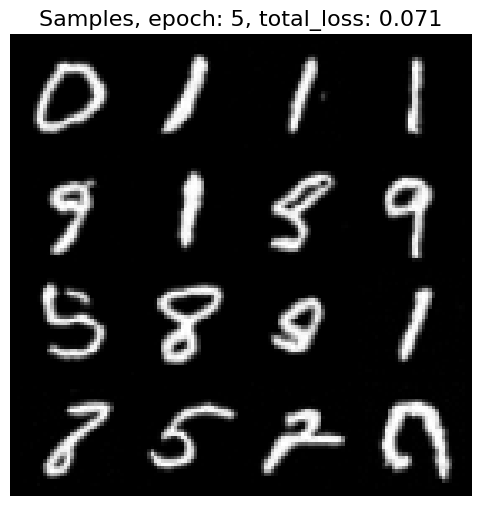

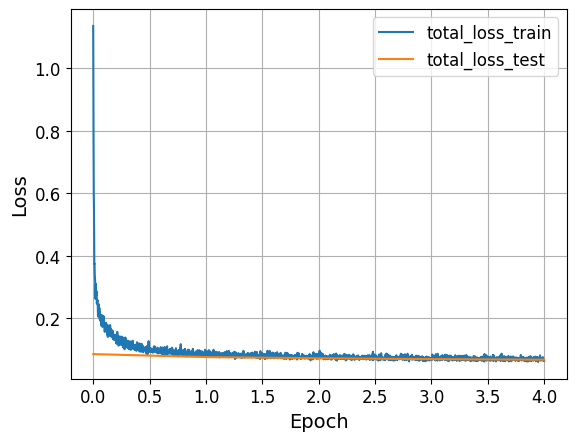

End of the training


In [ ]:
# ====
# your code
# choose these parameters
BATCH_SIZE =
LR =
EPOCHS =
HIDDEN_CHANNELS =
CHANNEL_MULTIPLIERS =
NUM_BLOCKS =
# ====

model = FlowMatchingModel(
    hidden_channels=HIDDEN_CHANNELS, 
    channel_multipliers=CHANNEL_MULTIPLIERS,
    num_blocks=NUM_BLOCKS,
)

train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE)

# choose any optimizer/scheduler as you want
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

train_model(
    model,
    train_loader,
    test_loader,
    epochs=EPOCHS,
    optimizer=optimizer,
    device=DEVICE,
    n_samples=16,
    visualize_samples=True,
)

# you might want to save the model
# torch.save(model.state_dict(), "flow_matching_model.pth")

Let's now sample images using different numbers of steps. With only 2 steps, the results are likely to be poor. In next tasks we will try to fix this problem.

In [ ]:
model.eval()
model.to(DEVICE)

num_samples = 100
samples_2 = model.sample(n=num_samples, num_steps=2)
samples_10 = model.sample(n=num_samples, num_steps=10)

show_samples(samples_2, title="Samples with 2 steps")
show_samples(samples_10, title="Samples with 10 steps")

## Task 3: Rectified flow (2 pt) 

One way to address this issue is by fine-tuning the model using training pairs sampled from the model itself. This approach was introduced in Rectified Flow [paper](https://arxiv.org/abs/2209.03003). 

Specifically, the process involves first generating noise–image pairs $(\mathbf{x}_0^*, \mathbf{x}_1^*)$, which are then used to retrain the model. Mathematically speaking, for any convex cost function $c$ (e.g., $\|\cdot\|^2$), the expected displacement under the generated pairs is smaller than that of the original data:

$$
\mathbb{E}[c(\mathbf{x}_1^* - \mathbf{x}_0^*)] \leq \mathbb{E}[c(\mathbf{x}_1 - \mathbf{x}_0)].
$$

As a result, the ODE trajectories tend to be shorter and empirically more direct, which can improve numerical stability and reduce the number of steps required for accurate integration. This procedure could be repeated multilple times.

In [ ]:
def prepare_dataset(
    model: BaseModel,
    num_steps: int,
    batch_size: int,
    train_size: int,
    test_size: int,
) -> Tuple[np.ndarray, ...]:
    train_noise = torch.randn(train_size, 1, 32, 32)
    test_noise = torch.randn(test_size, 1, 32, 32)

    train_x = np.empty_like(train_noise)
    test_x = np.empty_like(test_noise)
    
    # ====
    # your code
    # generate train and test samples

    # ====

    return train_x, train_noise, test_x, test_noise

In [ ]:
# you might want to load the model
# model.load_state_dict(torch.load("flow_matching_model.pth"))

model.eval()
model.to(DEVICE)

train_x, train_noise, test_x, test_noise = prepare_dataset(
    model, 
    num_steps=10,
    batch_size=BATCH_SIZE,
    train_size=len(train_data), 
    test_size=len(test_data)
)
train_data = LabeledDataset(train_x, train_noise)
test_data = LabeledDataset(test_x, test_noise)

Now we can fine-tune the model.

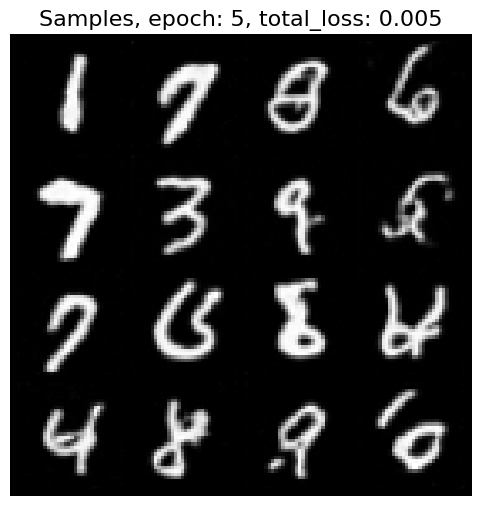

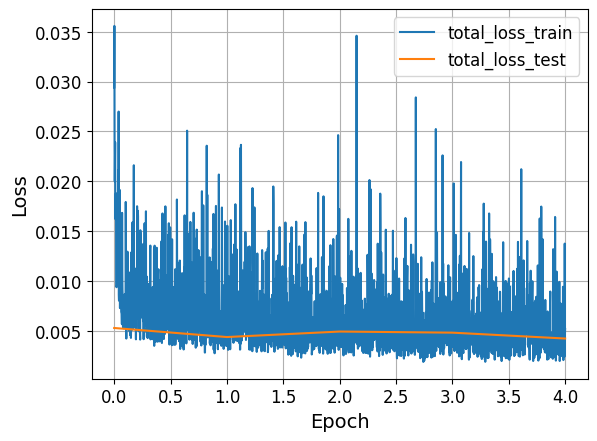

End of the training


In [ ]:
# ====
# your code
# choose these parameters
BATCH_SIZE =
LR =
EPOCHS =
# ====

train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE)

# choose any optimizer/scheduler as you want
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

train_model(
    model,
    train_loader,
    test_loader,
    epochs=EPOCHS,
    optimizer=optimizer,
    device=DEVICE,
    n_samples=16,
    visualize_samples=True,
    conditional=True
)

Here, you should obtain higher-quality images even with 2-step generation and similar with 10-step.

In [ ]:
model.eval()
model.to(DEVICE)

num_samples = 100
samples_2 = model.sample(n=num_samples, num_steps=2)
samples_10 = model.sample(n=num_samples, num_steps=10)

show_samples(samples_2, title="Samples with 2 steps")
show_samples(samples_10, title="Samples with 10 steps")

## Task 3: Flow matching with OT couplings (4 pt) 

Another way to reduce displacement under a given cost function is through **optimal transport (OT)**. The goal is to ensure that the generated sample $\mathbf{x}_1$ remains close to the original noise $\mathbf{x}_0$, under a cost function $c(\mathbf{x}_0, \mathbf{x}_1)$, such as $\|\mathbf{x}_1 - \mathbf{x}_0\|^2$. This leads to minimizing the **Wasserstein distance** between the distributions:

$$
W(p_0, p_1) = \inf_{\pi \in \Pi(p_0, p_1)} \mathbb{E}_{(\mathbf{x}_0, \mathbf{x}_1) \sim \pi}[\|\mathbf{x}_0 - \mathbf{x}_1\|^2],
$$

where $\Pi(p_0, p_1)$ is the set of all couplings with marginals $p_0$ and $p_1$.

In practice we skip the costly full-dataset OT and work inside each mini-batch. We treat the batch of images $ \{\mathbf{x}_0^{i}\}_{i=1}^{B}$ and the batch of noise $ \{\mathbf{x}_1^{j}\}_{j=1}^{B}$ as a vectors from uniform distributions $\mathbf{a}$ and $\mathbf{b}$. Next, we form the cost matrix $M_{ij} = \|\mathbf{x}_0^{i} - \mathbf{x}_1^{j}\|^{2}$ and find Wasserstein distance:

$$
\pi^\star = \arg\min_{\pi \in \Pi(\mathbf{a},\mathbf{b})} \langle \pi, M \rangle,
$$

to get the optimal transport plan $\pi^\star$.

We then sample index pairs $(i,j)$ according to the weights in $\pi^\star$ and train on the matched pairs $(\mathbf{x}_0^{i}, \mathbf{x}_1^{j})$. This keeps each image close to a nearby noise point, shrinking the mini-batch Wasserstein distance. For more, see [paper](https://arxiv.org/abs/2304.14772).


In [ ]:
train_data, test_data = load_dataset("mnist", flatten=False, binarize=False)
visualize_images(train_data, "MNIST samples")

Instead of coding an OT solver from scratch, we’ll rely on the [POT library](https://pythonot.github.io/).

In [ ]:
class FlowMatchingOTModel(FlowMatchingModel):
    def get_map(self, x: torch.Tensor, y: torch.Tensor):
        # ====
        # your code
        # 1) covert x and y to vectors
        # 2) apply Earth Movers distance solver with L2 cost matrix
        # NOTE: treat x and y as elements from uniform distribution

        # ====
        return p

    def sample_map(self, pi, batch_size):
        p = pi.flatten()
        p = p / p.sum()
        choices = np.random.choice(pi.shape[0] * pi.shape[1], p=p, size=batch_size)
        return np.divmod(choices, pi.shape[1])

    def sample_plan(self, x: torch.Tensor, y: torch.Tensor):
        pi = self.get_map(x, y)
        i, j = self.sample_map(pi, x.shape[0])
        return x[i], y[j]

    def loss(
        self, 
        x: torch.Tensor, 
        y: Optional[torch.Tensor] = None
    ) -> Dict[str, torch.Tensor]:
        if y is None:
            y = torch.randn_like(x, device=self.device)

        # ====
        # your code
        # 1) sample time uniformly from 0 to 1
        # 2) permute x and y using OT
        # 3) calculate x_t and optimal flow
        # 4) predict flow using model
        # 5) calculate loss

        # ====
        return {'total_loss': loss}


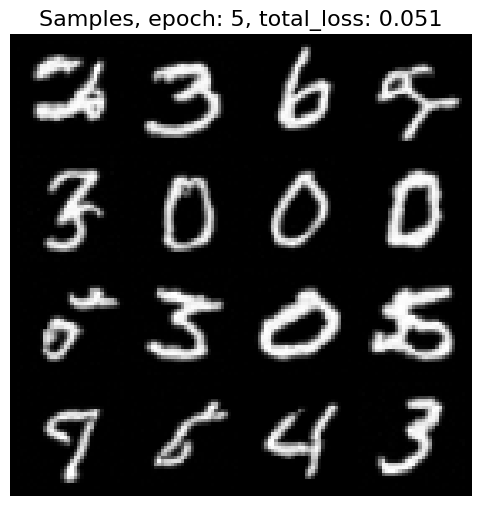

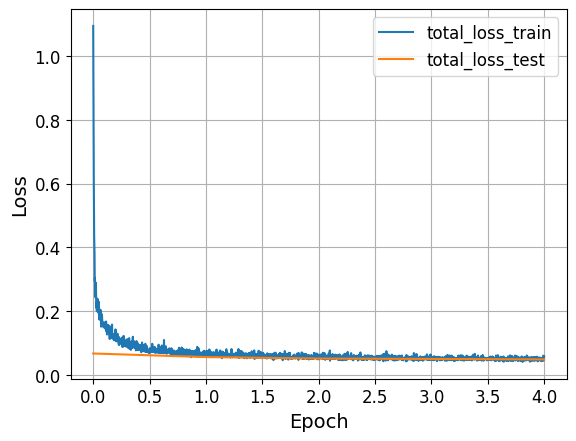

End of the training


In [ ]:
# ====
# your code
# choose these parameters
BATCH_SIZE =
LR =
EPOCHS =
HIDDEN_CHANNELS =
CHANNEL_MULTIPLIERS =
NUM_BLOCKS =
# ====

model = FlowMatchingOTModel(
    hidden_channels=HIDDEN_CHANNELS, 
    channel_multipliers=CHANNEL_MULTIPLIERS,
    num_blocks=NUM_BLOCKS,
)

train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE)

# choose any optimizer/scheduler as you want
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

train_model(
    model,
    train_loader,
    test_loader,
    epochs=EPOCHS,
    optimizer=optimizer,
    device=DEVICE,
    n_samples=16,
    visualize_samples=True,
)

With just two steps, the samples should improve over the original Flow matching baseline, but they’ll still fall short of the quality achieved by Rectified flow.

In [ ]:
model.eval()
model.to(DEVICE)

num_samples = 100
samples_2 = model.sample(n=num_samples, num_steps=2)
samples_10 = model.sample(n=num_samples, num_steps=10)

show_samples(samples_2, title="Samples with 2 steps")
show_samples(samples_10, title="Samples with 10 steps")